In [14]:
from main_class import PhysicsInformedGP_regressor
import numpy as np


### First example   
forced damped oscillator:   
\begin{equation}
 \ddot{x} + b\dot{x} + k x = f(t) \; \; \mathrm{ with \; m = 1}
\end{equation}

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:631: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:640: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


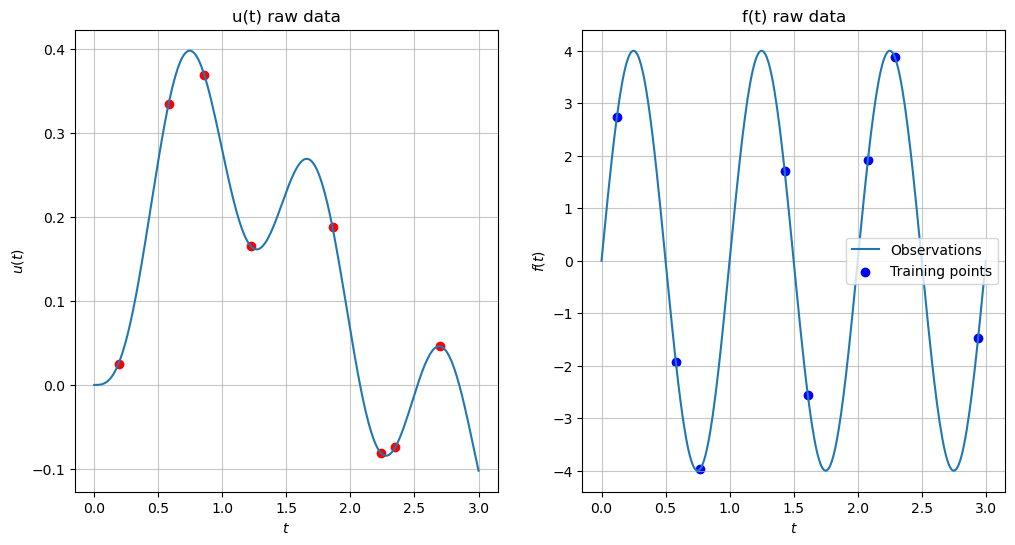

In [15]:
from kernels.kernel_oscillator import gram_Matrix, k_ff, k_uf, k_fu, k_uu
Kernel = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
params = ["l_x", "sigma_f_sq", "b", "k"]
model_1 = PhysicsInformedGP_regressor(kernel =Kernel, timedependence = False,params=params)
model_1.set_name_kernel("oscillator")
n_training_points = 8
noise = [1e-6,1e-6]
model_1.set_training_data("data_files/damped_m1k2b1.csv", n_training_points, noise)
model_1.set_validation_data(2000)
model_1.plot_raw_data(Training_points=True)



 C:\Users\Razer\AppData\Local\Temp\ipykernel_1720\2799943307.py:12: RuntimeWarning:covariance is not positive-semidefinite.


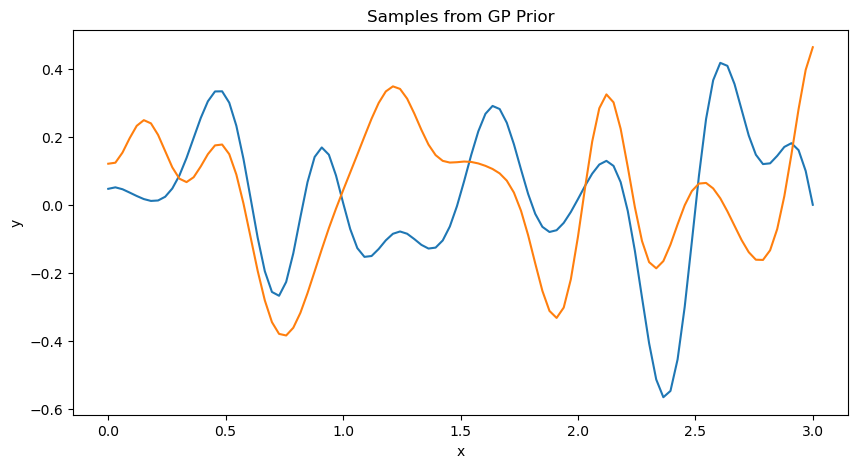

In [16]:
import matplotlib.pyplot as plt
n_functions = 2
n_samples = 100
# Sample x values
x = np.linspace(0, 3, n_samples)
x2 = np.linspace(0, 3, n_samples*2)
hyperparameters = [0.18916745, 0.04958991, 1, 5]
# Calculate the kernel matrix
K = k_fu(x, x, hyperparameters)

# Draw samples from a multivariate normal distribution
y_samples = np.random.multivariate_normal(mean=np.zeros(n_samples), cov=K, size=n_functions)
fig = plt.figure(figsize=(10, 5))
# Plot the samples
for i in range(n_functions):
    
    plt.plot(x, y_samples[i, :])

    plt.title('Samples from GP Prior')
    plt.xlabel('x')
    plt.ylabel('y')


In [17]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = rng.uniform(1, 3, 1)
    theta_initial[3] = rng.uniform(1, 3, 1)
    return theta_initial
n_iterations, n_threads = 1000, -1
model_1.train("TNC",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                            'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                            'gtol': 1e-8})

100%|██████████| 1000/1000 [02:52<00:00,  5.80it/s]


     fun: 0.1308460235595703
     jac: array([ 0.40234375,  0.08984375,  0.28344727, -0.07640076], dtype=float32)
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 87
     nit: 16
  status: 1
 success: True
       x: array([0.45983214, 0.38705502, 0.94838404, 1.53254783])


 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:396: RuntimeWarning:invalid value encountered in sqrt
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:397: RuntimeWarning:invalid value encountered in sqrt


-----------------------------------------------
GP with kernel: 
Training data: (8, 1)
Training targets: (16, 1)
Hyperparameters: {'l_x': 0.4598321388061144, 'sigma_f_sq': 0.387055017150581, 'b': 0.9483840425547085, 'k': 1.532547830444865}
Log marginal likelihood: 0.1308460235595703
Mean squared error: {'u': 5.28210039192345e-05, 'f': 0.10531028360128403}
-----------------------------------------------



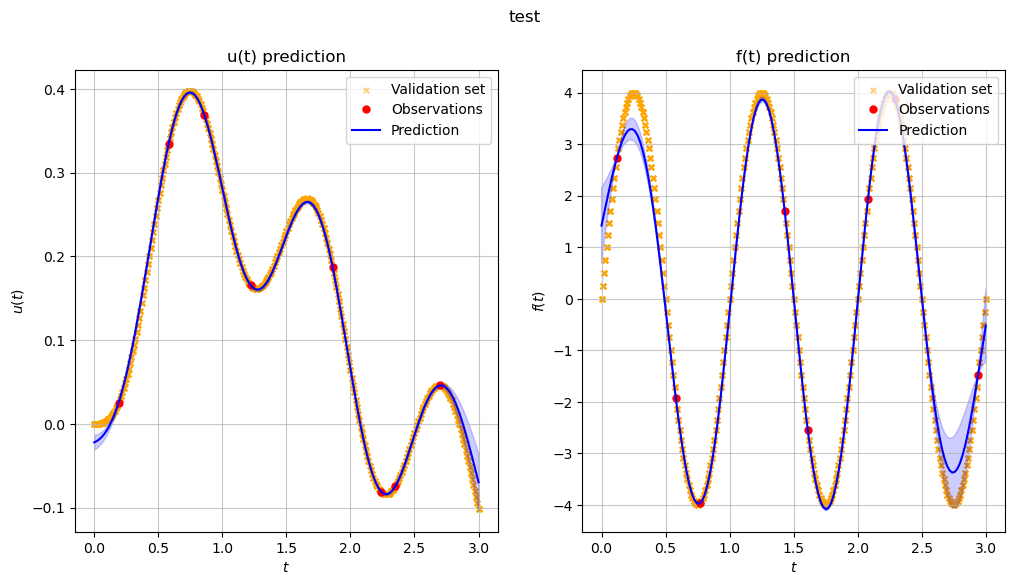

In [18]:
X_star = np.linspace(0,3,150).reshape(-1,1)
model_1.predict_model(X_star)
model_1.mean_u.shape
model_1.plot_prediction(X_star,"test","plots/oscillator/prediction_1d.png")
model_1.error()
print(model_1)

0.0006532127861193801


{'dataplot': [<matplotlib.collections.PathCollection at 0x1ef02b354f0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1ef047463d0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1ef047465e0>]}

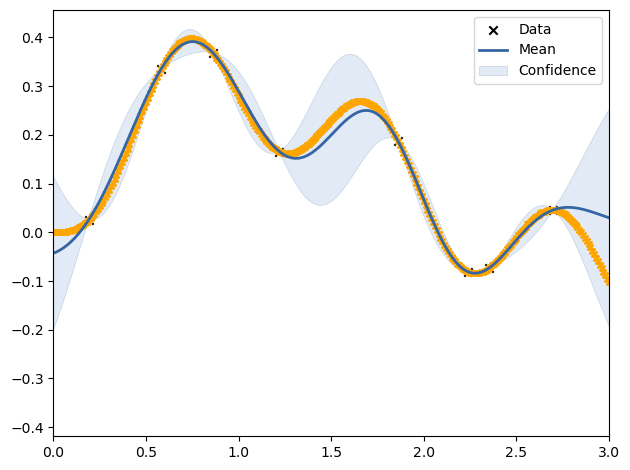

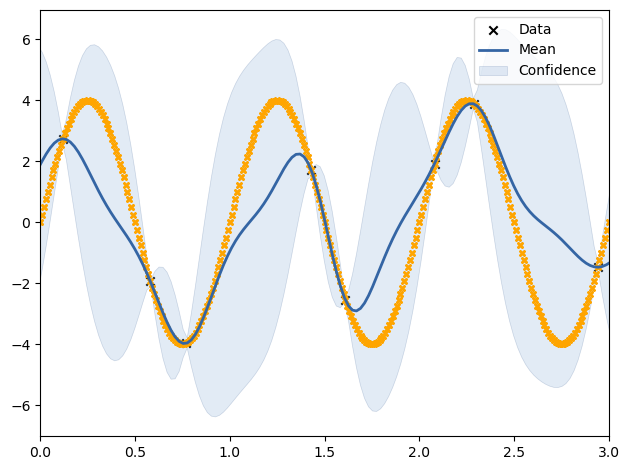

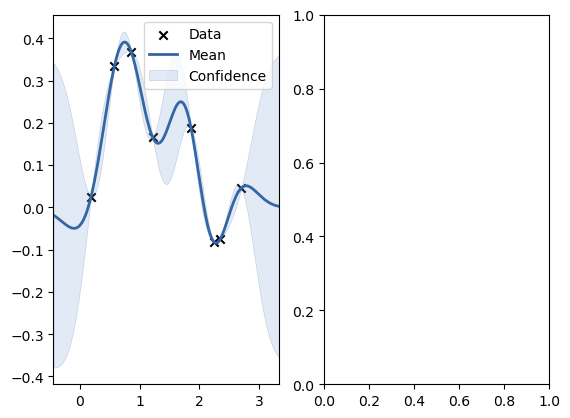

In [19]:
import GPy
import matplotlib.pyplot as plt
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model_GPy = GPy.models.GPRegression(model_1.X, model_1.u_train, kernel)
model_GPy.Gaussian_noise.variance.fix(noise[0])
model_GPy.optimize_restarts(num_restarts = 20, verbose=False)
model_GPy.plot()
plt.scatter(model_1.validation_set[0],model_1.validation_set[1], label = "validation set", color = "orange", marker = "x", s = 15)
plt.xlim(0,3)
kernel2 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model_GPy2 = GPy.models.GPRegression(model_1.Y, model_1.f_train, kernel2)
model_GPy2.Gaussian_noise.variance.fix(noise[1])
model_GPy2.optimize_restarts(num_restarts = 20, verbose=False)
model_GPy2.plot()
plt.scatter(model_1.validation_set[2],model_1.validation_set[3], label = "validation set", color = "orange", marker = "x", s = 15)
plt.xlim(0,3)

error = np.mean((model_1.validation_set[1]- model_GPy.predict(model_1.validation_set[0])[0])**2)
print(error)
fig, ax = plt.subplots(1,2)
model_GPy.plot(ax=ax[0])



### Second example
Wave equation:
\begin{equation}
 \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2} \; \; \mathrm{ with \; c = 3}
\end{equation}

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:657: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:667: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:698: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:708: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


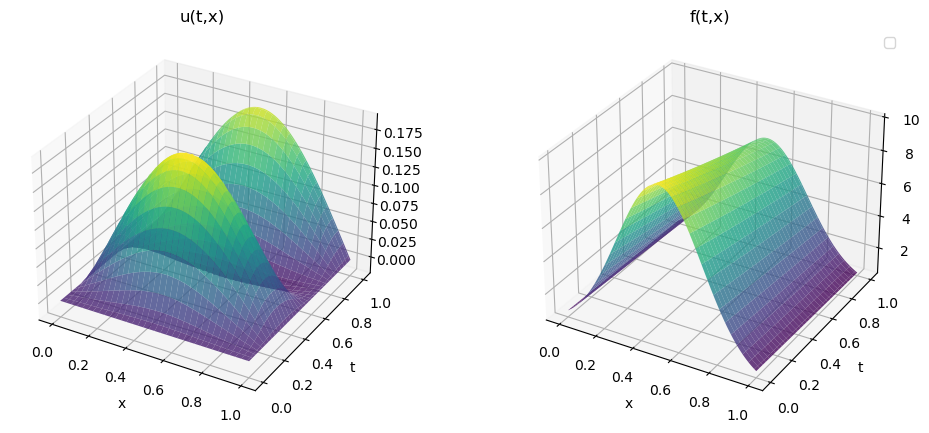

In [1]:
from main_class import PhysicsInformedGP_regressor
from kernels.kernel_helmholtz import gram_Matrix, k_ff, k_uf, k_fu, k_uu
from kernels.kernel_helmholtz import gram_Matrix_jax, k_ff_jax, k_uf_jax, k_fu_jax, k_uu
import numpy as np
Kernel = [gram_Matrix, k_uu, k_uf, k_fu, k_ff]
Kernel_jax = [gram_Matrix_jax, k_uu, k_uf_jax, k_fu_jax, k_ff_jax]
params = ["l_x", "sigma_f_sq", "l_t", "c"]
model_2 = PhysicsInformedGP_regressor(kernel =Kernel, timedependence = True,params=params)
model_2.set_name_kernel("helmholtz")
n_training_points = 20
noise = [1e-8,1e-8]
model_2.set_training_data("data_files/gaussian_f_c3.csv", n_training_points, noise)
model_2.set_validation_data(2000)
model_2.plot_raw_data()

In [2]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 1, 1)
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[3] = rng.uniform(1, 4, 1)
    return theta_initial
n_iterations, n_threads = 400, 8
model_2.train("TNC",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                                            'bounds': ((1e-2, None), (1e-5, None), (1e-3, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                                            'gtol': 1e-6})


100%|██████████| 400/400 [01:52<00:00,  3.57it/s]


ValueError: min() arg is an empty sequence

In [26]:
model_2.set_params([0.30128045, 0.01      , 0.23903748, 2.00648009])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Traced<ShapedArray(float32[20,20])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[10000,20])>with<DynamicJaxprTrace(level=1/0)>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Traced<ShapedArray(float32[2000,20])>with<DynamicJaxprTrace(level=1/0)>


 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:467: RuntimeWarning:invalid value encountered in sqrt


Traced<ShapedArray(float32[10201,20])>with<DynamicJaxprTrace(level=1/0)>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE_u:  7.415947834198734e-05
MSE_f:  4.36702331638556e-05
{'u': 3.005261896760203e-05, 'f': 0.6152334213256836}


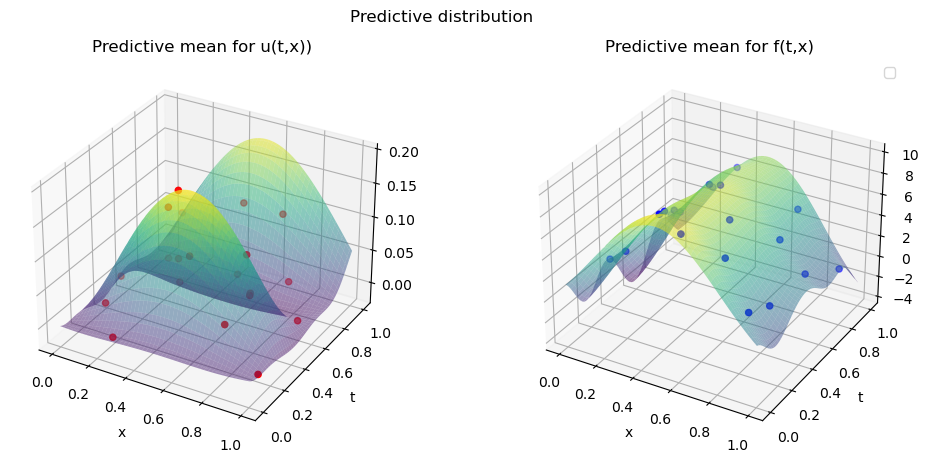

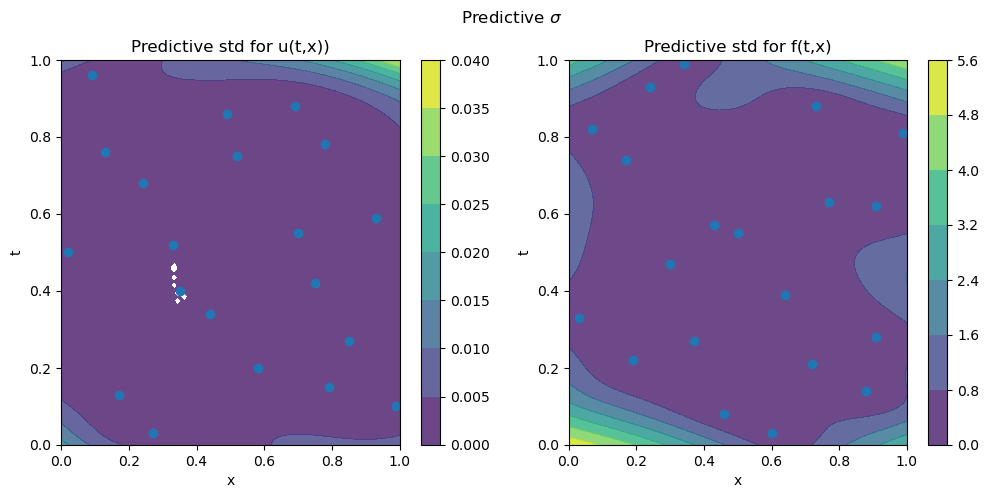

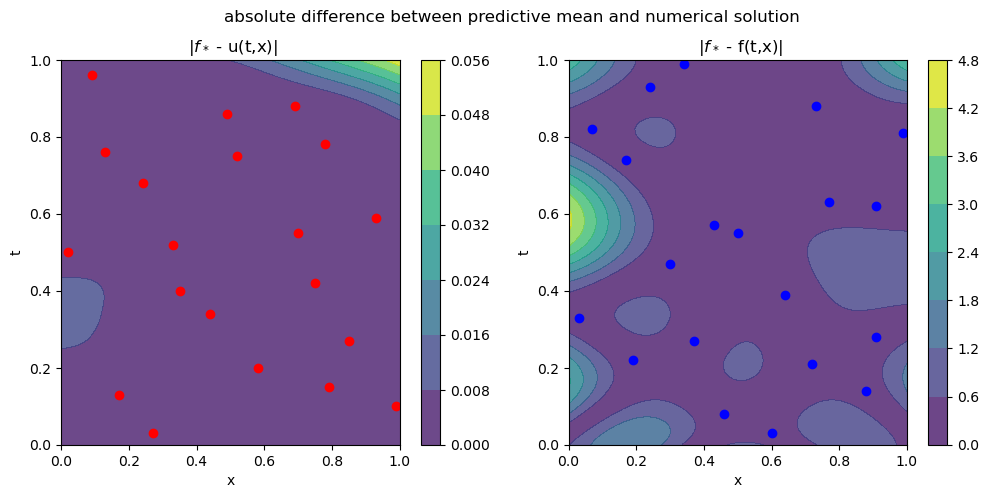

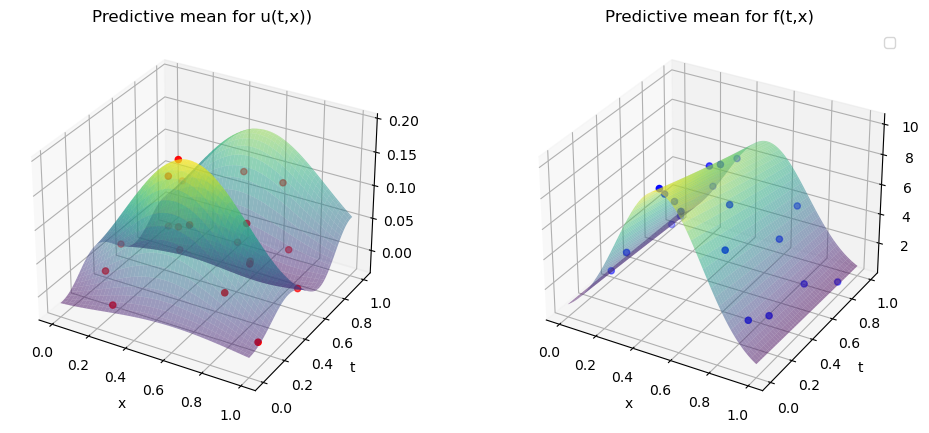

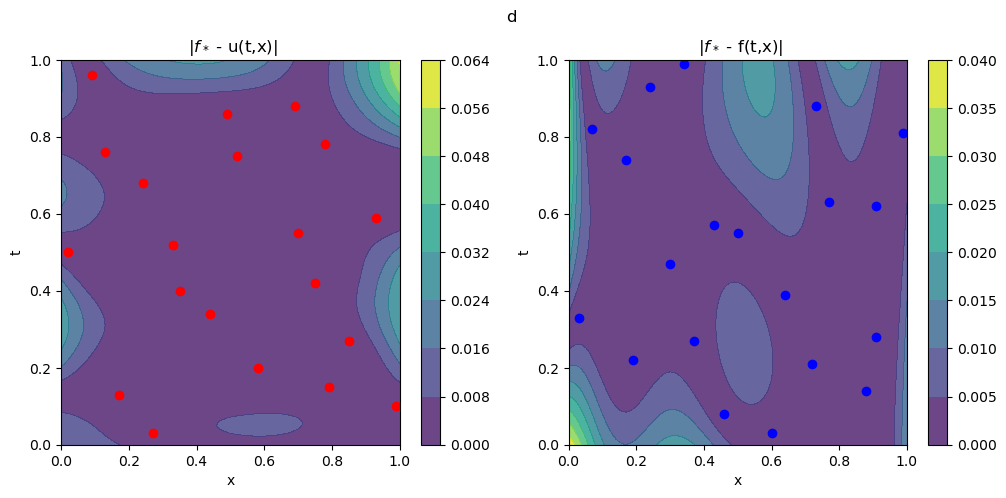

In [3]:
x_star, t_star = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
X_star = np.hstack((x_star.reshape(-1,1),t_star.reshape(-1,1)))
model_2.predict_model(X_star)

model_2.var_u.shape
model_2.plot_prediction(X_star,"Predictive distribution","plots/wave_eq/prediction_2d.png")
model_2.error()
model_2.plot_variance(X_star,"Predictive $\\sigma$","plots/wave_eq/variance_2d.png")
model_2.plot_difference("absolute difference between predictive mean and numerical solution","plots/wave_eq/difference_2d.png")
#print(model_2)
model_2.use_GPy(X_star)
model_2.plot_difference_GPy("d",None)
print(model_2.MSE)

 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:674: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:684: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:715: UserWarning:The balance properties of Sobol' points require n to be a power of 2.
 c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\PI_GP_regressor\main_class.py:725: UserWarning:The balance properties of Sobol' points require n to be a power of 2.


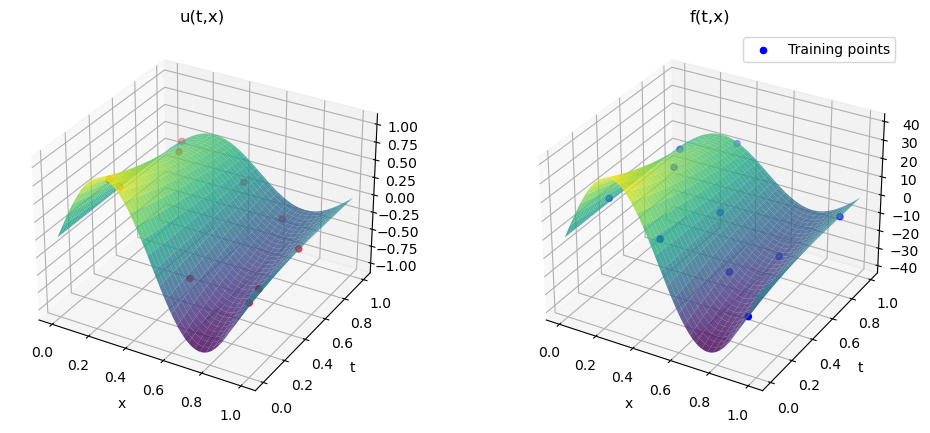

In [4]:
from main_class import PhysicsInformedGP_regressor
from kernels.kernel_heat_equation import k_ff_jax, k_uf_jax, k_fu_jax, k_uu_jax, gram_Matrix_jax
kernel = [gram_Matrix_jax,k_uu_jax, k_uf_jax, k_fu_jax, k_ff_jax]
params = ["l_x", "sigma_f_sq", "l_t", "alpha"]
model3 = PhysicsInformedGP_regressor(kernel=kernel,timedependence=True,params=params)
noise = [0.0000001,0.0000001]
model3.set_training_data("data_files/heat_data_paper.csv",10,noise)
model3.plot_raw_data(Training_points=True)
model3.set_validation_data(2000)

In [7]:
import numpy as np
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[3] = rng.uniform(1, 4, 1)
    return theta_initial
n_iterations, n_threads = 200, 8
model3.train("TNC",n_iterations,n_threads,{'theta_initial': get_initial_values,   #needed for all optimization methods
                                            'bounds': ((1e-2, None), (1e-2, None), (1e-5, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                                            'gtol': 1e-8})
 #needed for all optimization methods

100%|██████████| 200/200 [01:20<00:00,  2.49it/s]


     fun: 15.002754211425781
     jac: array([-10.345703  ,  -0.10984802,   0.6419792 ,  -3.6871948 ],
      dtype=float32)
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 83
     nit: 15
  status: 1
 success: True
       x: array([0.33071554, 1.96395451, 1.42091917, 0.9850638 ])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MSE_u:  0.0018797906456309297
MSE_f:  10.483411437703113


{'u': 0.0005989684141241014, 'f': 0.9428260326385498}

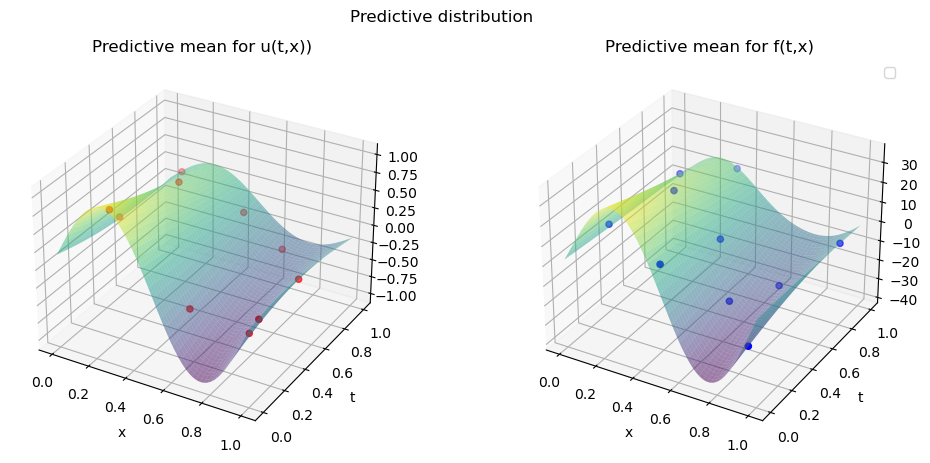

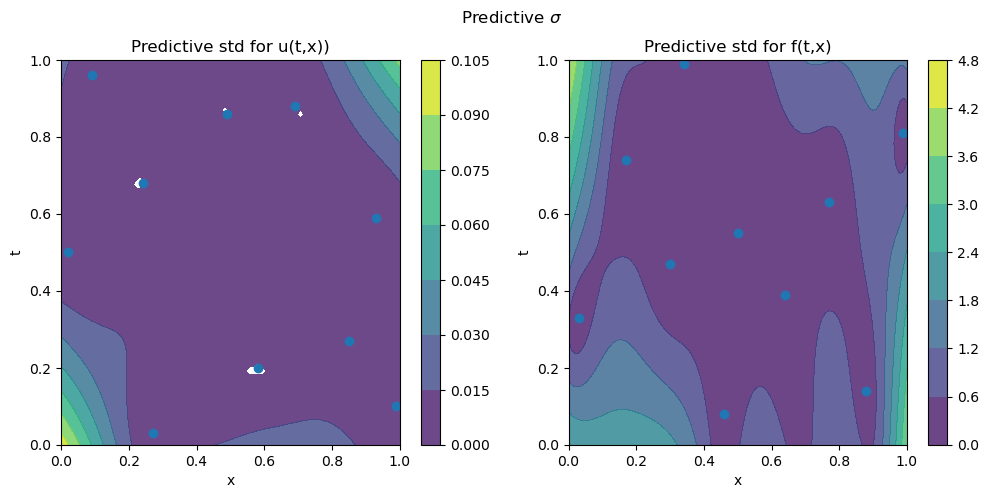

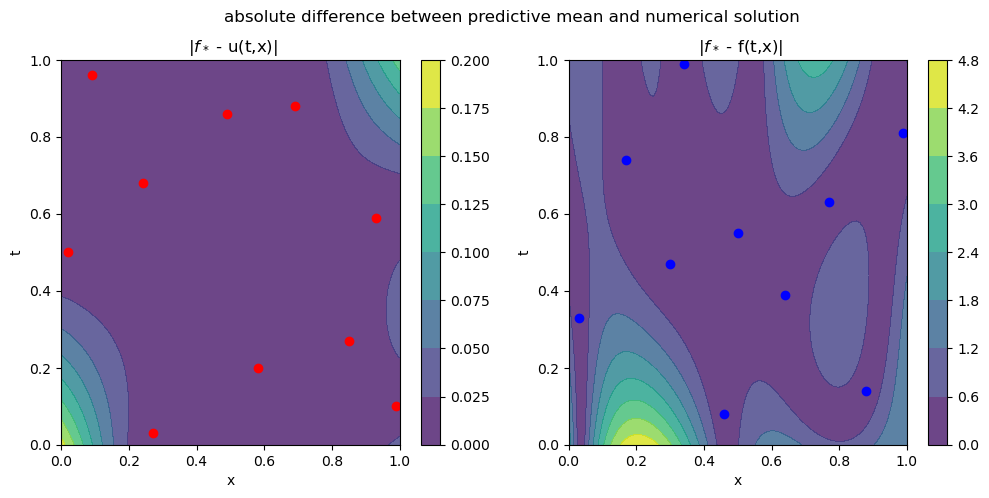

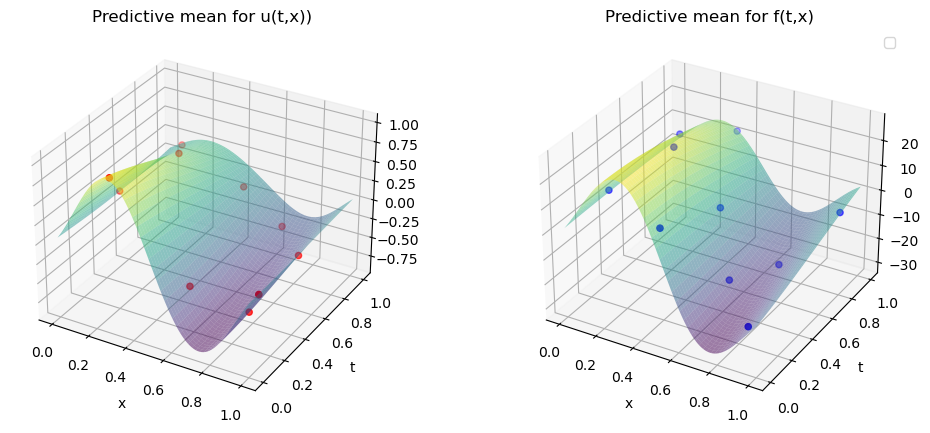

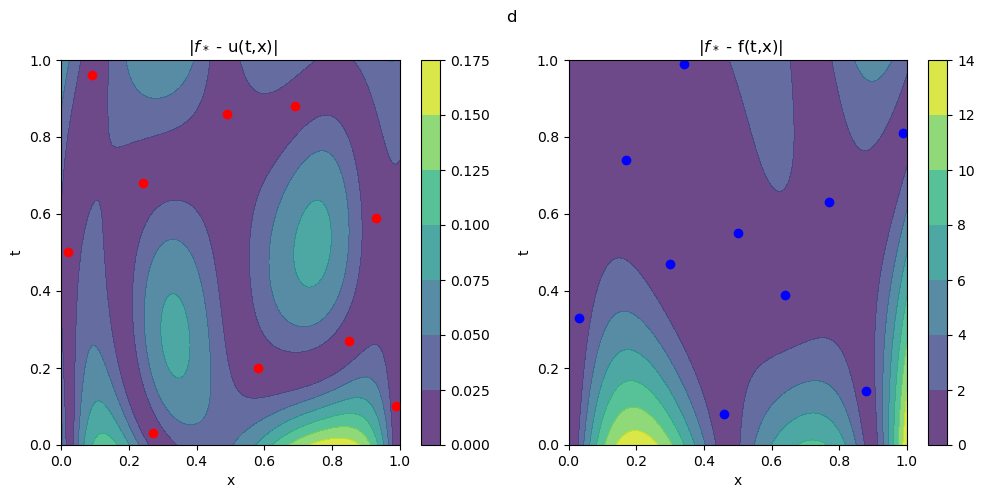

In [8]:
x_star, t_star = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
X_star = np.hstack((x_star.reshape(-1,1),t_star.reshape(-1,1)))
model3.predict_model(X_star)

model3.var_u.shape
model3.plot_prediction(X_star,"Predictive distribution","plots/wave_eq/prediction_2d.png")
model3.error()
model3.plot_variance(X_star,"Predictive $\\sigma$","plots/wave_eq/variance_2d.png")
model3.plot_difference("absolute difference between predictive mean and numerical solution","plots/wave_eq/difference_2d.png")
#print(model_2)
model3.use_GPy(X_star)
model3.plot_difference_GPy("d",None)
model3.MSE